<a href="https://colab.research.google.com/github/ASKanse/CS419/blob/master/lab12_outlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Images Using Metric learning** 

As you perhaps noted in Lab04 (problem on "Attendance"), before you try to match, it is a good idea to visualize the clustering of the data.  The goal of the *inlab* is to consider potential situations that you may encounter in clustering. The *outlab* goal is to solve the problems encountered.

In this exercise we use metric learning to cluster images of the characters '4' and '9' from the MNIST dataset. To this end, we create pairs of images having either similar or dissimilar content. An image pair is semantically similar (aka *positive*) if both the images are from the same class and dissimilar (aka *negative*) otherwise. We train a Siamese Network (recall lab on March 6) with these pairs along with a contrastive loss. The equation of the contrastive loss is as follows:

$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{\max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$
where $x_0, x_1$ are image pairs and the label $y$ is 1 for a *positive* pair and 0 otherwise.


#### We start downloading a curated subset of the MNIST data consisting of digits 4 and 9. The "aug" version consists  of an augmented test dataset that contains horizonatal translations of the pixel contents. The value of the translation comes from the set {-6, -3, +3, +6}.

In [4]:
!wget https://www.dropbox.com/s/fdw52tpo0in0pnk/test_4_9_aug.pickle 
!wget https://www.dropbox.com/s/f6mqhcjz4qqjom2/test_4_9.pickle 
!wget https://www.dropbox.com/s/9wy3o13oiw27mgt/train_4_9.pickle

--2020-03-18 07:45:49--  https://www.dropbox.com/s/fdw52tpo0in0pnk/test_4_9_aug.pickle
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fdw52tpo0in0pnk/test_4_9_aug.pickle [following]
--2020-03-18 07:45:50--  https://www.dropbox.com/s/raw/fdw52tpo0in0pnk/test_4_9_aug.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8144f065193bd4f06482c3a870.dl.dropboxusercontent.com/cd/0/inline/A0JAkLrTwG1qHHCWFXh-f96Blt6m5onivxnJ61TxWXV_yMy_DCvcEj4YP2nHe8HoaiYDVgejICwAeybTJ0boFvbbZtsBKJ49bP8h3fCFk07uCNvp-_5_vlNp8AZTYuUIn_4/file# [following]
--2020-03-18 07:45:50--  https://uc8144f065193bd4f06482c3a870.dl.dropboxusercontent.com/cd/0/inline/A0JAkLrTwG1qHHCWFXh-f96Blt6m5onivxnJ61TxWXV_yMy_DCvcEj4YP2nHe8HoaiYDVgejICwAeybTJ0boFvbbZt

In [0]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import cv2
import os
import math
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt


In [34]:
data_path = os.path.join('{0}_4_9.pickle'.format('train'))
with open(data_path, 'rb') as f:
    load_dict = pickle.load(f)
print(load_dict.keys())
data = load_dict['data']
pairs4 = load_dict['pairs_4']
pairs9 = load_dict['pairs_9'] 
class_labels = load_dict['target']
print(data.shape)
print(class_labels.shape)
print(pairs4.shape)
print(pairs9.shape)

data_path = os.path.join('{0}_4_9.pickle'.format('train'))
with open(data_path, 'rb') as f:
    load_dict = pickle.load(f)
data = load_dict['data']
#aug_labels = load_dict['aug_labels']
pairs = load_dict['pairs_4']
pairs2 = load_dict['pairs_9'] 
class_labels = load_dict['target']
# print(pairs.shape)
# print(pairs2.shape)
# print(load_dict.keys())
print("Pairs corresposding to first 4 are")
for i in range(15):
    print(pairs[i])
print("Pairs corresposding to 9 are")
for i in range(15):
    print(pairs2[i])
# print(type(data))
# print(data.shape)
# print(type(class_labels))
# print(class_labels.shape)
# print(class_labels[1])
labels_set = set(class_labels)
# label_to_indices = {label: }
# print(label_to_indices[4])
print('\n loaded {} samples'.format(data.shape[0]))
target = np.random.randint(0, 2)
index = 0
img1, label1 = data[index], class_labels[index]
print(type(label1))
a = data[0].flatten()/255.
#print(a[200:400])
for i in range(20):
    print(pairs4[i, 1])
    b = data[pairs4[i, 1]].flatten()/255.
    print(np.sum(a*b)/(np.sqrt(np.sum(a*a))*np.sqrt(np.sum(b*b))))
fours=load_dict['data'][:3000]
zero=fours[0]
dots=[ np.sum(x[:]*zero[:])/(np.sqrt(np.sum(x[:]*x[:]))*np.sqrt(np.sum(zero[:]*zero[:]))) for x in fours]
# print(dots)
#print(zero.flatten()[200:400])
print(np.array(dots).argsort()[::-1][1:10])
# print(load_dict['pairs_4'][:10])

dict_keys(['data', 'target', 'pairs_4', 'pairs_9'])
(6000, 28, 28)
(6000,)
(15000, 2)
(15000, 2)
Pairs corresposding to first 4 are
[   0 1549]
[  0 707]
[   0 1701]
[   0 1107]
[   0 1838]
[   1 2174]
[   1 1503]
[ 1 23]
[   1 1508]
[   1 1072]
[  2 595]
[  2 152]
[  2 435]
[   2 1790]
[  2 631]
Pairs corresposding to 9 are
[   0 1850]
[ 0 64]
[  0 189]
[   0 1894]
[  0 338]
[   1 2683]
[  1 408]
[   1 1571]
[   1 1315]
[   1 2477]
[   2 2016]
[  2 798]
[ 2 56]
[   2 1941]
[   2 2518]

 loaded 6000 samples
<class 'numpy.int64'>
1549
0.8905275639806782
707
0.874735708666293
1701
0.8712321056303326
1107
0.8673515027346715
1838
0.8556866362572487
2174
0.5648836115380831
1503
0.6258730020401995
23
0.5910853974362593
1508
0.7265222279321051
1072
0.617636620027138
595
0.46279543195652106
152
0.36195718017764816
435
0.4872187984715778
1790
0.46723349173158896
631
0.44134556195337016
1818
0.7975070255825578
2416
0.787496840679014
242
0.8432769664850973
1148
0.7676252136574307
703
0.7837463632

#### Some relevant packages (typical Python Packages)

#### Data loader providing 'positive' and 'negative' pairs for training a siamese network.
### Notes
We are collecting the pairs of positive and negative in the class variable 'pairs'. In the code below, the positive pairs object is a three tuple, where the first item is an even number. There is no particular reason that this should be the case.
###Questions

1.   The mean listed is the mean of the entire MNIST data (after normalizing pixel values in the range [0..1]. Update the mean and standard deviation to reflect that we are loading only the characters '4' and '9'.  (Note you can leave this alone without getting stuck for this assignment).
2.   Is the 233rd item in the train data a '4' or a '9'?  (Note we are counting from 0)
3.   What are the indices of the images for the 466th test pair fed to the network? (Note we are counting from 0)
4.   With respect to the pairs of images fed to the network, what is your guess of the maximum value of a scalar that the network sees as the input? We are looking for a symbolic answer?
5.   How many '4's are present in the train dataset?







In [0]:
from time import sleep

In [0]:
# Changed to train with nearest neighbours only
# for outlab metric learning exercise
class MNIST_SIAM(data.Dataset):
    def __init__(self, split='train', aug=False):

        print('Creating {} data'.format(split))

        self.split = split
        self.aug = aug
        
        if self.aug is False:
            data_path = os.path.join('{}_4_9.pickle'.format(split))
        else:
            data_path = os.path.join('{}_4_9_aug.pickle'.format(split))

        with open(data_path, 'rb') as f:
            load_dict = pickle.load(f)
            
        self.data = load_dict['data']
        # Take mean of entire data, divide by 255 
        # To normalize like final data
        self.mean = self.data.mean()/255.   
        # Get std dev of data
        self.std = self.data.std()/255.
        self.class_labels = load_dict['target']
        self.pairs4 = load_dict['pairs_4']
        self.pairs9 = load_dict['pairs_9'] 
        # Create a minimal set out of possible labels
        # In our case just {4,9}
        self.labels_set = set(self.class_labels)
        self.label_to_indices = {label: np.where(self.class_labels == label)[0] for label in self.labels_set}
        print('\n loaded {} samples'.format(self.data.shape[0]))

        # This does not need to change since is only used to calculate 
        # validation loss
        if split == 'test':
            random_state = np.random.RandomState(1)
            positive_pairs = [[i, random_state.choice(
                self.label_to_indices[self.class_labels[i]]), 1] for i in range(0, len(self.data), 2)]
            negative_pairs = [[i, random_state.choice(
                self.label_to_indices[np.random.choice(
                    list(self.labels_set - set([self.class_labels[i]])))]), 0] for i in range(1, len(self.data), 2)]

            self.pairs = positive_pairs + negative_pairs
            print('Created {} pairs'.format(len(self.pairs)))

    def __getitem__(self, index):
        if self.split == 'train':
            # Get a 0/1 random number
            target = np.random.randint(0, 2)
            # Read in the image and corresponding label
            # present at the current index
            img1, label1 = self.data[index], self.class_labels[index]
            # If random no. was 1 create a positive pair
            # The method for making this +ve pair has been modified for outlab 
            if target == 1:
                # Select a buddy lying in the size 5 NN collection for current label

                if label1 == 4:
                    siamese_index = np.random.choice(self.pairs4[index*5: index*5 + 5][:, 1])
                else:
                    siamese_index = np.random.choice(self.pairs9[(index-3000)*5: (index-3000)*5 + 5][:, 1]) 
            # Else create a negative pair, this part remains the same as in-lab
            else:
                # Choose any random label other than true label to creare a negative pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                # Choose any random index of data corresponding to this true label
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            # Pick the image correponding to the -ve/+ve pair
            img2 = self.data[siamese_index]
        
        # Else if test (rather validation) data then pairs have been prepared 
        else:
            img1 = self.data[self.pairs[index][0]]
            img2 = self.data[self.pairs[index][1]]
            target = self.pairs[index][2]

        img1 = img1.astype('float32') / 255.
        img2 = img2.astype('float32') / 255.

        img1_norm = (img1 - self.mean) / (self.std + 1e-06)
        img2_norm = (img2 - self.mean) / (self.std + 1e-06)

        meta = {'img1': img1, 'img2': img2}

        return img1, img2, target, meta

    def __len__(self):
        return self.data.shape[0]


#### The MNIST_BASIC class is used to visualize the images. Once our Siamese network is trained, we feed all the images to the network and look at the embedding

In [0]:
class MNIST_BASIC(data.Dataset):
    def __init__(self, split='train', aug=False):

        print('Creating {} data'.format(split))

        self.split = split
        self.aug = aug

        if self.aug is False:
            data_path = os.path.join('{}_4_9.pickle'.format(split))
        else:
            data_path = os.path.join('{}_4_9_aug.pickle'.format(split))

        with open(data_path, 'rb') as f:
            load_dict = pickle.load(f)

        self.data = load_dict['data']
        self.class_labels = load_dict['target']
        
        self.mean = self.data.mean()/255. 
        self.std = self.data.std()/255.

        if self.aug is True:
            self.aug_labels = load_dict['aug_labels']

        print('\n loaded {} samples'.format(self.data.shape[0]))

        self.n_samples = self.data.shape[0]

    def __getitem__(self, index):
        img1, label1 = self.data[index], self.class_labels[index]

        img1 = img1.astype('float32') / 255.

        img1_norm = (img1 - self.mean) / (self.std + 1e-06)

        meta = {'img1': img1}

        return img1_norm, label1, meta

    def __len__(self):
        return self.n_samples


#### This is the Siamese network discussed on March 6.  The  basic model (EmbeddingNet) consists of a CNN followed by a FCN with an output embedding size of 2. To implement the "Siamese" nature of the network, we call this basic model twice in the wrapper Siamese network
### Questions


1.   What is the size of the output embedding?  Why was this number chosen?
2.   Fill in at the location shown as 'FILL'



In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 16, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(16, 64, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 5 * 5, 256),
                                nn.PReLU(),
                                nn.Linear(256, 64),
                                nn.PReLU(),
                                nn.Linear(64, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x2)  # DO NOT CHANGE
        output2 = self.embedding_net(x1)
        return  output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

#### The contrastive loss

In [0]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared dMINistances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


#### Functions used in plotting the embedding space.

In [0]:
mnist_classes = ['4', '9']
colors = ['#1f77b4', '#ff7f0e']

mnist_aug_classes = [-6, 6]
aug_legends = ['4-6', '4+6', '9-6', '9+6']
aug_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
#              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']


def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        inds = np.where(targets == int(mnist_classes[i]))[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

    plt.show(block=True)


def plot_embeddings_aug(embeddings, targets, shifts, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    
    for i in range(2):
        for j in range(2):
            inds_aug = np.where(np.logical_and(targets == int(mnist_classes[i]), shifts == mnist_aug_classes[j]))[0]

            plt.scatter(embeddings[inds_aug, 0], embeddings[inds_aug, 1], alpha=0.5, color=aug_colors[i*2+j])
    
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])

    plt.legend(aug_legends)

    plt.show(block=True)


#### Function for extracting embeddings from images using MNIST_BASIC dataloader object.
##### Fill in the location shown as 'FILL'

In [0]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target, meta in dataloader:
            images = images.unsqueeze(1).cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

#### Training / Testing the model for an epoch

In [0]:
def run_epoch(data_loader, model, loss_fn, optimizer, log_interval, split='train'):

    if split == 'train':
        model.train()
    else:
        model.eval()

    losses = []
    total_loss = 0

    for batch_idx, (img1, img2, target, meta) in enumerate(data_loader):
        target = target if len(target) > 0 else None

        img1 = img1.unsqueeze(1).cuda()
        img2 = img2.unsqueeze(1).cuda()
        target = target.cuda()

        optimizer.zero_grad()
        outputs1, outputs2 = model(img1, img2)

        loss_outputs = loss_fn(outputs1, outputs2, target)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()

        if split == 'train':
            loss.backward()
            optimizer.step()

        if batch_idx % log_interval == 0:
            message = '{}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(split,
                batch_idx * img1.shape[0], len(data_loader.dataset),
                100. * batch_idx / len(data_loader), np.mean(losses))

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss


#### Function used to train/test model for 'n_epochs'.

In [0]:
def fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, log_interval, start_epoch=0):
 
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss = run_epoch(train_loader, model, loss_fn, optimizer, log_interval, split='train')

        val_loss = run_epoch(test_loader, model, loss_fn, optimizer, log_interval, split='test')
        val_loss /= len(test_loader)

#### Creating the dataloader and model
Notes:
The margin for the contrastive loss is set to 1.  This is simply a hyperparameter

In [262]:
train_dataset_siam = MNIST_SIAM(split='train', aug=False)
test_dataset_siam = MNIST_SIAM(split='test', aug=False)

batch_size = 128
margin = 1.

train_loader_siam = torch.utils.data.DataLoader(train_dataset_siam, batch_size=batch_size, shuffle=True)
test_loader_siam = torch.utils.data.DataLoader(test_dataset_siam, batch_size=batch_size, shuffle=False)

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

model = model.cuda()

loss_fn = ContrastiveLoss(margin)
loss_fn = loss_fn.cuda()

Creating train data

 loaded 6000 samples
Creating test data

 loaded 1800 samples
Created 1800 pairs


#### Creating optimiser and learning scheduler

In [0]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 15, gamma=0.1, last_epoch=-1)
n_epochs = 250
log_interval = 10 



#### Calling 'fit' function to train model

In [268]:
fit(train_loader_siam, test_loader_siam, model, loss_fn, optimizer, scheduler, n_epochs, log_interval)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train: [0/6000 (0%)]	Loss: 0.097443
train: [1280/6000 (21%)]	Loss: 0.086494
train: [2560/6000 (43%)]	Loss: 0.088863
train: [3840/6000 (64%)]	Loss: 0.085192
train: [5120/6000 (85%)]	Loss: 0.082670
test: [0/1800 (0%)]	Loss: 0.004880
test: [1280/1800 (67%)]	Loss: 0.046438
train: [0/6000 (0%)]	Loss: 0.091090
train: [1280/6000 (21%)]	Loss: 0.086284
train: [2560/6000 (43%)]	Loss: 0.087115
train: [3840/6000 (64%)]	Loss: 0.084387
train: [5120/6000 (85%)]	Loss: 0.085251
test: [0/1800 (0%)]	Loss: 0.008942
test: [1280/1800 (67%)]	Loss: 0.036346
train: [0/6000 (0%)]	Loss: 0.080083
train: [1280/6000 (21%)]	Loss: 0.082700
train: [2560/6000 (43%)]	Loss: 0.089123
train: [3840/6000 (64%)]	Loss: 0.087982
train: [5120/6000 (85%)]	Loss: 0.082668
test: [0/1800 (0%)]	Loss: 0.008866
test: [1280/1800 (67%)]	Loss: 0.042537
train: [0/6000 (0%)]	Loss: 0.092677
train: [1280/6000 (21%)]	Loss: 0.086904
train: [2560/6000 (43%)]	Loss: 0.083770
train: [3840/6000 (64%)]	Loss: 0.083858
train: [5120/6000 (85%)]	Loss: 0.0

####  Defining MNIST_BASIC train and test dataloaders 

In [269]:
train_loader_basic = torch.utils.data.DataLoader(MNIST_BASIC(split='train', aug=False), batch_size=batch_size,
                                                 shuffle=False)
test_loader_basic = torch.utils.data.DataLoader(MNIST_BASIC(split='test', aug=False), batch_size=batch_size,
                                                 shuffle=False)

test_loader_basic_aug = torch.utils.data.DataLoader(MNIST_BASIC(split='test', aug=True), batch_size=batch_size,
                                                 shuffle=False)


Creating train data

 loaded 6000 samples
Creating test data

 loaded 1800 samples
Creating test data

 loaded 3600 samples


#### Visualizing Train and Test dataset embedding space. **This is the main part of the inlab**

### Questions

1.   Write your conclusions on the 3 different plots given.  Specifically, will you trust this embedding to differentiate the two characters in both the test datasets?  Which particular type of character creates the maximum confusion?
2.   For your outlab, we want to you to (later on) update the notebook so that this confusion is reduced. Provide some idea on how this should be done in this inlab.



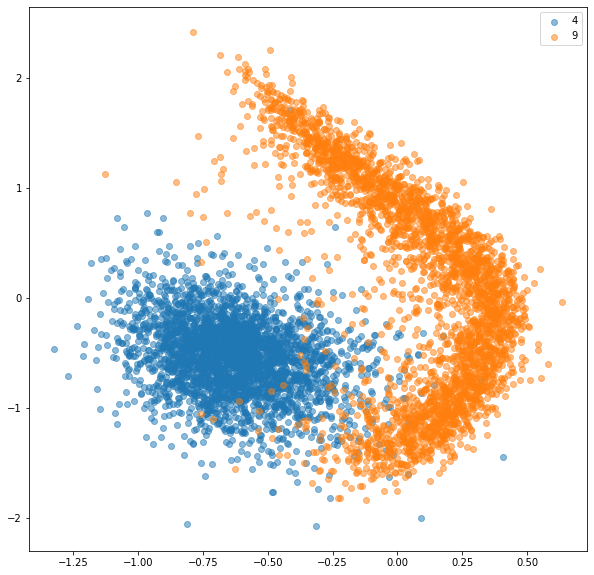

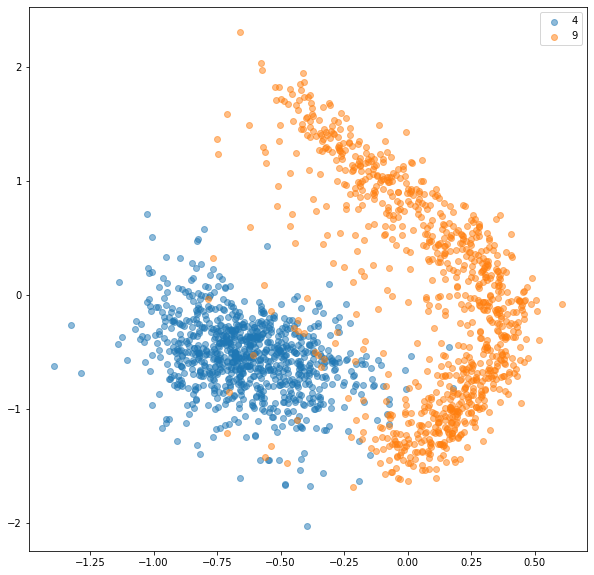

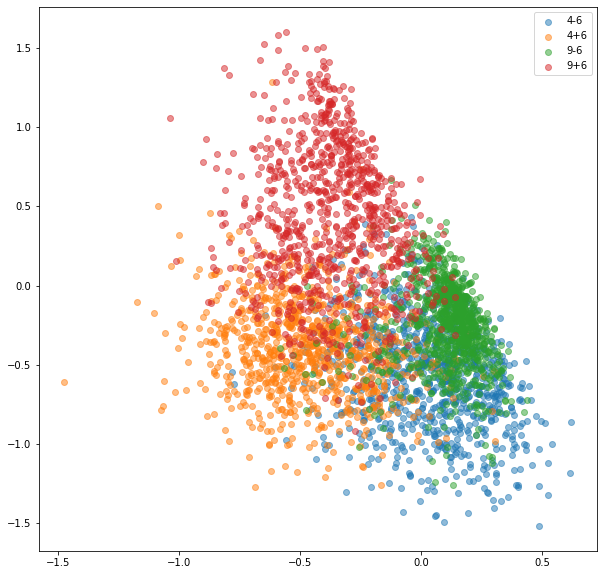

In [270]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader_basic, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader_basic, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)
val_embeddings_aug, val_labels_aug = extract_embeddings(test_loader_basic_aug, model)
plot_embeddings_aug(val_embeddings_aug, val_labels_aug, test_loader_basic_aug.dataset.aug_labels)
